利用加州人口普查信息，建立一个加州房价模型

本章勘误： 72页 特征缩放第三段最后一行，StandadScaler -> StandardScaler

此外，注释暂不讨论的地方，或为暂不清楚

TOC

# 获取数据

In [1]:
import os
import tarfile
import urllib
DOWNLAOD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'  # 根url
HOUSING_PATH = os.path.join('datasets','housing')
HOUSING_URL = DOWNLAOD_ROOT + 'datasets/housing/housing.tgz'  # 创建下载链接

def fetch_housing_data(housing_url=HOUSING_URL, hosuing_path=HOUSING_PATH):
    os.makedirs(hosuing_path, exist_ok=True)  # 创建目录
    tgz_path = os.path.join(hosuing_path, 'housing.tgz')  # 创建压缩文件路径
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=hosuing_path)
    housing_tgz.close()

In [2]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):  # 定义函数直接取特定数据
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

> 以上脚本用函数编写的目的在于，函数的参数是默认的，需要调用时直接引用，无需调用时可以直接取到本地的数据

In [3]:
housing = load_housing_data()
housing.head()  # 展示数据头

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()  # 信息摘要

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts()  # 具体字段数据统计

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()  # 描述统计

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# 总体数据分布情况可视化

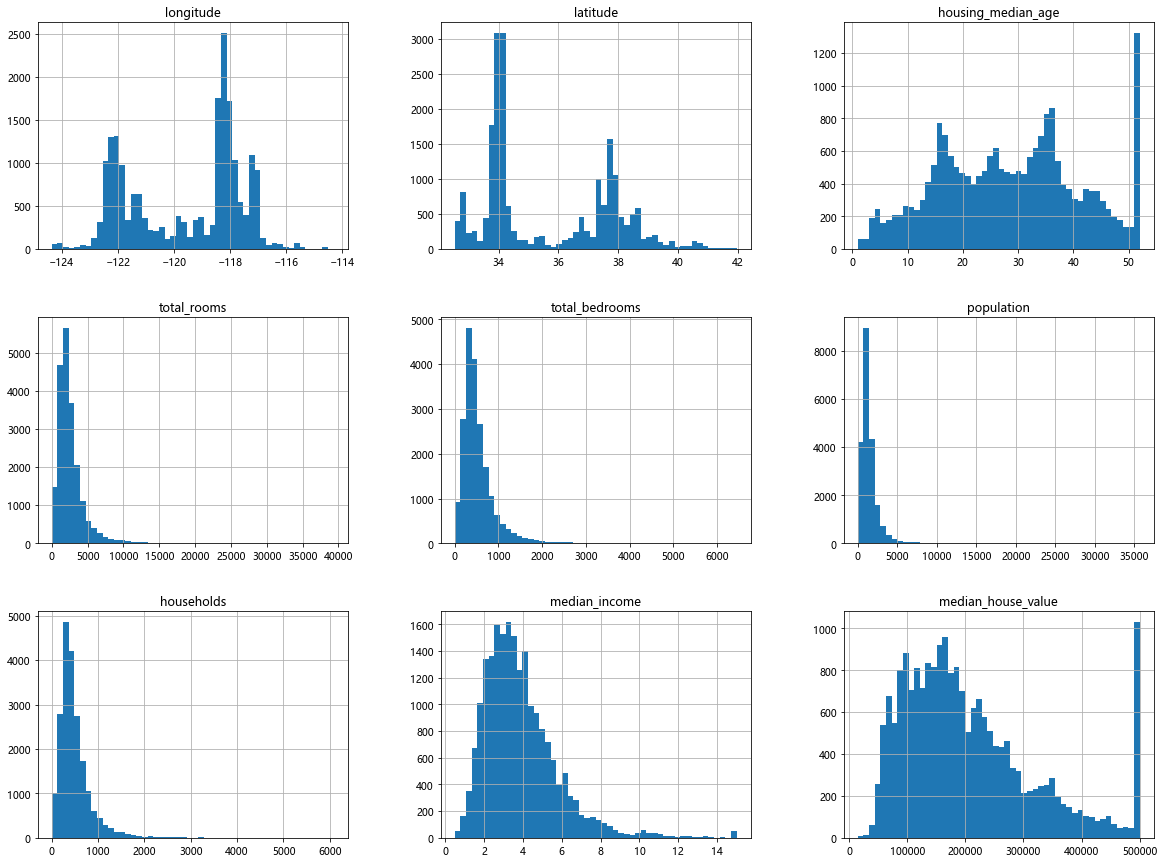

In [7]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 正常显示中文
housing.hist(bins=50, figsize=(20,15))  # 对面板数据作图 
plt.show()

# 数据分割

## 随机抽样分割

In [8]:
from sklearn.model_selection import train_test_split  # 方法1，随机抽样
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)  # 原数据切割为训练集和测试集
# train_test_split(数据集，测试集比例，随机数种子)

## 分层随机抽样分割
> 分层随机抽通常使得训练集和测试集与原数据的某一特征的分布一致，随机抽样则通常有偏，此处是按照收入中位数的分布进行分层

In [9]:
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'],
                                bins = [0, 1.5, 3.0, 4.5, 6, np.inf],
                                labels=[1, 2, 3, 4, 5])
# pd.cut(数列，分割标志，类别标签)

<AxesSubplot:>

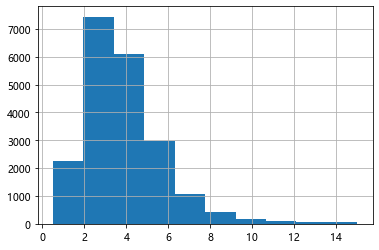

In [10]:
housing['median_income'].hist()  # 收入分布情况直方图

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit  # 方法2，分层随机抽样（此处按照收入中位数分层效果较好）

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# StratifieldShuffleSplit(分组个数，测试集比例，随机数种子) ，可以用于交叉验证
for train_index, test_index in split.split(housing, housing['income_cat']):
    # .split(x, y) 将x按照y中数据类别比例进行等比划分
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)  # 验证各收入群体在样本中比例是否保持一致

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

## 恢复为数据原有字段

In [14]:
for set_ in (strat_train_set, strat_test_set):  # 将两个集内的'income_cat'字段遍历删除（恢复数据字段原样）
    set_.drop('income_cat', axis=1, inplace=True)  # axis=1 是找行 axis=0是找列（默认）

> 此时我们已经有训练集strat_train_set和测试集strat_test_set，将测试集strat_test_set放在一边，而strat_train_set经过处理在后面会赋值给housing

## 人口与房价的位置分布散点图

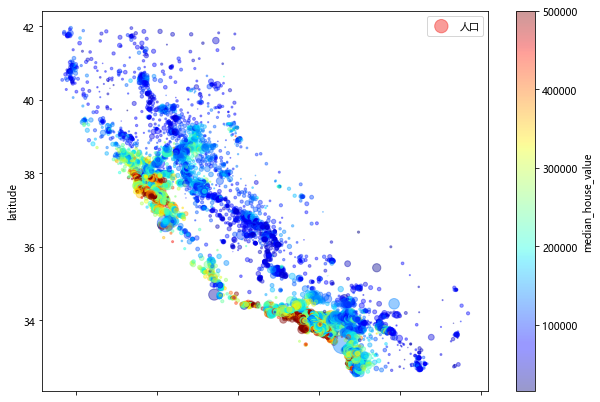

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='人口', figsize=(10,7),
            c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True)  
            # alpha 透明度，s 散点大小（人口数），c 散点颜色（房价中位数）
plt.show()

## 研究相关系数

### 方法1，直接观察相关系数列表

In [16]:
corr_matrix = housing.corr()  # 得出一个相关系数矩阵

In [17]:
corr_matrix['median_house_value'].sort_values(ascending=False)  # 查看与房价中位数有关的相关系数，按照降序排列
# 可以发现收入中位数相关性最高，纬度呈一定的负相关性，越往北，价格倾向于下降

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

### 方法2，通过散点图矩阵观察相关性

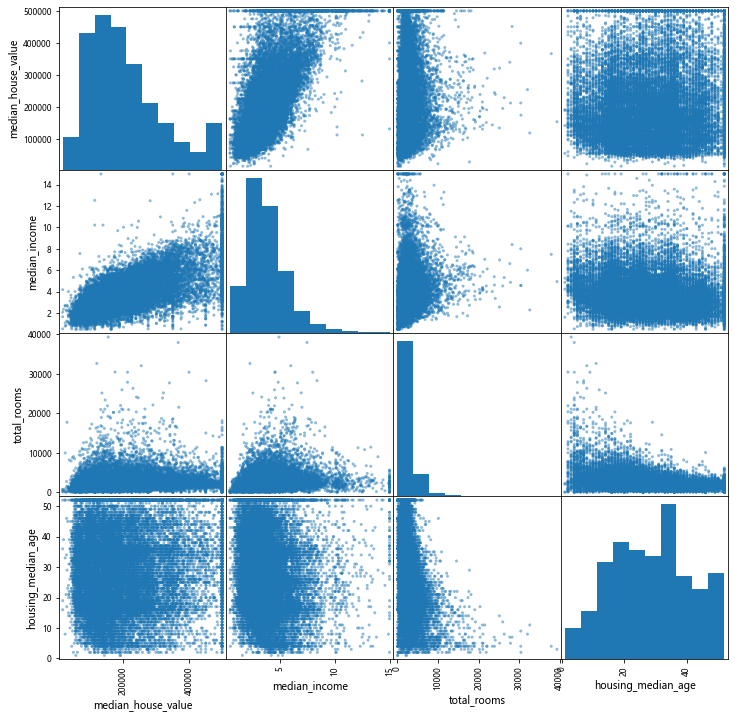

In [18]:
from pandas.plotting import scatter_matrix  # pandas的散点图包
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']  
# 只选取部分属性，否则将有11^2 = 121 个散点图
scatter_matrix(housing[attributes], figsize=(12, 12))  # 注意：第一个参数实际上是housing[[...,...,...]]
plt.show()
# 此处相关系数矩阵主对角线图像显示的是该字段数据的直方图（原本应该是一条直线（自己与自己相关系数是1），没有意义）
# 左下方和右上方三角形区域的图像是一样（对称）的，只是方向变了

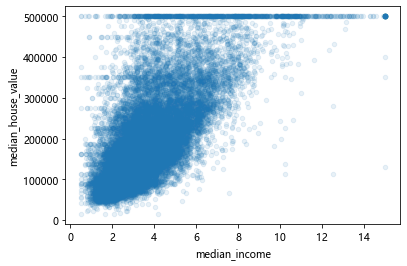

In [19]:
housing.plot(kind='scatter', x='median_income', y='median_house_value',alpha=0.1)  # 单独来看房价和收入中位数的散点图
plt.show()

## 尝试构造新的属性

也可以通过后面的流水线实现

In [20]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']  # 家庭均房数
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']  # 房均卧室数
housing['population_per_household'] = housing['population'] / housing['households']  # 家庭均人口数

In [21]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

> 其中 bedrooms_per_room 和 rooms_per_household 都表现出较为显著的相关关系

> 显然，房均卧室数越低越贵（人的居住空间较大），家庭均房数越高越贵（一个家庭所有的房间越多越贵）

In [22]:
housing = strat_train_set.drop('median_house_value', axis=1)  # 生成没有目标值（标签）的面板（去掉房价中位数）
housing_labels = strat_train_set['median_house_value'].copy()  # 标签单独提出来（拷贝一个）【标签通常都是拷贝而非直接赋值】

> housing和housing_labels 均为训练集的数据和标签，在训练模型中将直接用housing

# 机器学习数据准备

## 数据清洗（数值型）

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # 建立一个实例
housing_num = housing.drop('ocean_proximity', axis=1)  # 去掉文本属性'位置'，否则无法计算中位数
imputer.fit(housing_num)  # 用该实例训练数据（算出中位数）

SimpleImputer(strategy='median')

> 注意，这里之所以变量叫housing_num，是因为删去了文本属性，剩下的都是数值属性，后面用流水线转化数值数据时会用到

In [24]:
imputer.statistics_  # 中位数保存在 .statistics_ 属性中

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [25]:
X = imputer.transform(housing_num)  # X 赋值为填补缺失值后的面板数据（ .transform(面板数据) 函数用于填补缺失值）
# X是np数组，还要转化为DF数据
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
# 字段和索引都还原，赋值给新变量housing_tr

> hosuing_tr 后缀意思是transformed 

In [26]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


## 处理文本和分类属性

### 方法1 直接编号

除非只有两个类，否则不推荐

In [27]:
housing_cat = housing[['ocean_proximity']]  # 注意外层还要用中括号嵌套，这样出来的是DF数据表

> 命名为housing_cat是因为：categories

In [28]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()  # 创建实例
housing_cat_encoder = ordinal_encoder.fit_transform(housing_cat)  # .fit_transform 直接训练并转化数据,输出np数组
housing_cat_encoder[:10]  # 注意：np数组没有 .head() 方法，要预览只能用索引 [:]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [29]:
ordinal_encoder.categories_  # 分类情况存在 .categories_ 属性中

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 方法2 独热编码

In [30]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()  # 创建实例
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) 
# 此时的 housing_cat_1hot 是Scipy稀疏矩阵，仅储存非0数据位置以节约空间，但可以像ndarray数组一样使用
housing_cat_1hot.toarray()  # 也可以转化为ndarray矩阵
cat_encoder.categories_ # 查看属性

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 自定义转换器（可选）

> 定义一个类，使得一个实例（面板数据）可以用来转换（增加）数据
参考 https://blog.csdn.net/dss_dssssd/article/details/82824979

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6  # 列中字段的列数(第几列)
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):  
    # 超参数 BaseEstimator：__init__函数不能接受参数，自定义分类器和转换器一般都带该闭包，暂不讨论
    # TransformerMinxin：自动实现fit_transform()函数，继承方法：fit_transform() <=> fit().transform()
    def __init__(self, add_bedrooms_per_room = True):
        # 如果在创建实例时参数设置为False，则不添加‘房均卧室数’这个属性，默认是添加的
        self.add_bedrooms_per_room = add_bedrooms_per_room  # 赋值
    def fit(self, X, y=None):
        return self  # fit() 方法不进行任何操作
    def transform(self, X):  # 转换器方法（添加新的字段）
        rooms_per_houshold = X[:, rooms_ix] / X[:, households_ix]  # 计算新的属性值（家庭均房间数）-> 必加
        population_per_household = X[:, rooms_ix] / X[:, rooms_ix]  # 计算家庭均人口数 -> 必加
        if self.add_bedrooms_per_room:  # 如果在创建实例时参数设置为True（默认情况），则添加‘房均卧室数’
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_houshold, population_per_household, bedrooms_per_room]  # 添加‘房均卧室数’
        else:
            return np.c_[X, rooms_per_houshold, population_per_household]  # 仅添加另外两个，不加上‘房均卧室数’
        # np.c_[] 的作用是拼接列，即横向拼接，要求行数相同，np.r_[]是拼接行，要求列数相等
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)  # 不加‘房均卧室数’
housing_extra_attribs = attr_adder.transform(housing.values)  # attr_adder.fit_transform(housing.values)

> 可见，自定义转换器一般要带有fit()和transform()函数，其中fit()函数必须返回self，这样可以继承TransformerMixin的fit_transform()方法

## 特征缩放

即归一化和标准化，这里不专门写，在后面整合流水线中用到

In [32]:
# MinMaxScaler 归一化，可用 feature_range 调整范围，默认是0~1
# StandardScaler 标准化，转换为均值为0，方差为1的数表

## 转换流水线（自动化转换）

### 数值型处理流水线

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # 标准化函数
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)  # 流水线一次性转换

### 处理文本流水线和整合流水线

In [34]:
from sklearn.compose import ColumnTransformer  # 该模块顾名思义，对列字段进行转换
num_attribs = list(housing_num)  # 获得全部字段 'longitude','latitude','housing_median_age','total_rooms'等
cat_attribs = ['ocean_proximity']  # 类别名称列表
# 整合流水线
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),  # 对数值字段进行前段已经定义过的流水线转换，这里仅需写实例名称'num_pipeline'
    ('cat', OneHotEncoder(), cat_attribs),  # 对文本字段进行热独编码转换
])
housing_prepared = full_pipeline.fit_transform(housing)  # housing_prepared意为准备完毕的数据，housing是原始数据

> 注意，此时的housing_prepared是ndarray矩阵，full_pipeline为全流水线实例

> 至此完成数据预处理全部内容

# 选择和训练模型

先康康准备好的数据集

In [35]:
pd.DataFrame(housing_prepared).head()  # 可见是标准化且加了热独编码的

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,0.0,0.155318,1.0,0.0,0.0,0.0,0.0
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,0.0,-0.836289,1.0,0.0,0.0,0.0,0.0
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,0.0,0.422200,0.0,0.0,0.0,0.0,1.0
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.0,-0.196453,0.0,1.0,0.0,0.0,0.0
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,0.0,0.269928,1.0,0.0,0.0,0.0,0.0


## 训练

## 1. 线性回归

In [36]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()  # 建立线性回归实例
lin_reg.fit(housing_prepared, housing_labels)  # 训练（称 lin_reg 为训练有素的模型）

LinearRegression()

> housing是训练集数据，前面已有说明

### 简单评估训练集

仅选小部分数据，规范评估参照后面的K折交叉验证

In [37]:
# 仅选前五个
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)  # 流水线处理数据

预览一下模型输出和实际数值

In [38]:
print('预测：',lin_reg.predict(some_data_prepared))
print('实际：',some_labels.values)  

预测： [210528.01750105 317824.00920324 210815.82440675  59307.5245779
 189946.78983305]
实际： [286600. 340600. 196900.  46300. 254500.]


可见效果很一般

In [39]:
from sklearn.metrics import mean_squared_error  # 计算均方差
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)

In [40]:
lin_rmes = np.sqrt(lin_mse)  # 均方差开方
print(lin_rmes)  # 输出标准差

68635.59352516982


> 收入中位数分布在120000~265000美元之间，因此平均误差68635虽然不算很高，但也不好

## 2. 决策树

In [41]:
from sklearn.tree import DecisionTreeRegressor  # 决策树回归模型
tree_reg = DecisionTreeRegressor()  # 创建实例
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [42]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


标准差为0，绝逼过拟合了。。

## K折交叉验证（规范评估方法）

> K折验证得出的若干值是在若干训练集上得到的标准误差

In [43]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_socres = np.sqrt(-scores)  # 该功能倾向于效用函数（越大越好），因此是负的MSE，计算标准差要先加负号，暂不详细讨论

In [44]:
# 编写一个函数用于输出结果
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [45]:
display_scores(tree_rmse_socres)

Scores: [70028.82471325 66302.74832819 73686.99531736 72162.34917078
 71112.31718492 74334.94256115 69966.09543395 68226.86000369
 69297.34831427 67305.1536788 ]
Mean: 70242.36347063378
Standard deviation: 2495.6533464646527


效果不好，比线性回归更差，线性回归的均方差是68635，决策树的平均均方差70719

## 3. 随机森林

原理在该章节不做详细解释，毕竟我现在也不会QAQ

In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)  # 训练有素

RandomForestRegressor()

算标准差

In [51]:
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18438.629814822852


K折验证

In [47]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=5)
forest_rmse_socres = np.sqrt(-scores)  # 该功能倾向于效用函数（越大越好），因此是负的MSE，计算标准差要先加负号，暂不详细讨论

In [48]:
display_scores(forest_rmse_socres)

Scores: [48107.13516188 50468.82036079 51144.62021336 50554.91858655
 51290.65579934]
Mean: 50313.23002438249
Standard deviation: 1148.5684174725402


> 虽然效果比决策树和线性回归好，但是K折验证表明，在训练集上的分数仍然远低于验证集，因此还存在过拟合

## 保存模型

In [55]:
import joblib
joblib.dump(forest_reg, 'my_model.pkl')  # 保存模型，以随机森林模型forest_reg为例
forest_reg = joblib.load('my_model.pkl')  # 读取模型

# 调整模型

> 调整模型的参数，使得效果更佳

In [58]:
from sklearn.model_selection import GridSearchCV
# 暂不讨论这里为什么选择超参数'n_estimators'和'max_features'的问题，在第七章解释
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10],'max_features':[2, 3, 4]},
]
# 参数网格第一个中包含3*4=12种情况，第二个中包含2*3=6种情况，共18种情况进行验证，此外bootstrap设为False（默认True），原因暂不讨论
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)  # 开始搜索最佳参数
grid_search.best_params_  # 输出最佳参数，在属性 .best_params_ 中

{'max_features': 8, 'n_estimators': 30}

找到最佳参数，8和30

In [64]:
grid_search.best_estimator_  # 查看最佳估算器

RandomForestRegressor(max_features=8, n_estimators=30)

In [65]:
cvres = grid_search.cv_results_  # 获取搜索结果的分数
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):  # 查看所有评估分数
    print(np.sqrt(-mean_score), params)

66322.2696968549 {'max_features': 2, 'n_estimators': 3}
57243.857389650446 {'max_features': 2, 'n_estimators': 10}
54748.1832031759 {'max_features': 2, 'n_estimators': 30}
62731.36004489283 {'max_features': 4, 'n_estimators': 3}
54710.39709522822 {'max_features': 4, 'n_estimators': 10}
52015.10588431504 {'max_features': 4, 'n_estimators': 30}
61835.40025204167 {'max_features': 6, 'n_estimators': 3}
53409.97490263277 {'max_features': 6, 'n_estimators': 10}
51519.09814692738 {'max_features': 6, 'n_estimators': 30}
59581.65067568064 {'max_features': 8, 'n_estimators': 3}
53188.53578121055 {'max_features': 8, 'n_estimators': 10}
51421.428213915526 {'max_features': 8, 'n_estimators': 30}
64215.25994316389 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
56384.578453453505 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61287.53315775133 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
54549.69818578652 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

> 最佳分数：53188.53578121055 {'max_features': 8, 'n_estimators': 10}

## 分析最佳模型及其误差（略）

 查看各个特征的重要性，可以删除无关特征，检查系统的具体错误并解决

## 用测试集评估系统

In [71]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()  # 拷贝而非赋值

X_test_prepared = full_pipeline.transform(X_test)  # 流水线处理数据
final_predictions = final_model.predict(X_test_prepared)  # 进行预测

final_mes = mean_squared_error(final_predictions, y_test)
final_rmse = np.sqrt(final_mes)  # 得出标准差
print(final_rmse)

48064.019102038736


至少比之前强...
实际上这里标准差属于是点估计，利用scipy可以得出置信区间

In [75]:
from scipy import stats
confidence = 0.95  # 置信度
squared_errors = (final_predictions - y_test) ** 2  # 算误差平方，squared_errors实际上是ndarray
np.sqrt(stats.t.interval(confidence, 
                         len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))  # 置信区间
# stats.t.interval(置信度，自由度，均值，标准差)

array([46133.96601883, 49919.50564514])

# 系统上线和维护

可以部署到服务器，设定自动定期调整超参数，定期监控输入的数据，发现异常现象（如特征预测标准差越来越大），注意保存旧模型，以防新模型出现严重问题

单纯对一个问题进行静态研究则无需此步骤